In [ ]:
!pip install konlpy

     |████████████████████████████████| 19.4 MB 1.4 MB/s 
     |████████████████████████████████| 448 kB 41.8 MB/s 


In [ ]:
!pwd

/content


In [ ]:
%cd /content/drive/MyDrive/cakd5_colab/project2

/content/drive/MyDrive/cakd5_colab/project2


In [ ]:
!ls

'강사님 자료'	     genre.pickle       __pycache__
 genre2.pickle	     genre-tfidf2.dic   tfidf2.py
 genre-model2.hdf5   genre-tfidf.dic    네이버_뉴스_tfidf_분류.ipynb
 genre-model.hdf5    news.csv	        tfidf.py


In [ ]:
import pandas as pd

texts = pd.read_csv('news.csv',index_col=0)
print(texts.shape)
texts

(4359, 3)


,article,target,category
0,별도 반응 없어수사기소 분리 공감한 것 해석도 법사위 제소위원회 서울연합뉴스 백승렬...,0,0
1,이해충돌 소지 없고 자문 역할만 충실 한덕수 국무총리 후보자가 일 오전 서울 종로구...,0,0
2,김오수 검찰총장과 분 면담서 검찰에 자기 개혁자정 노력 당부 검찰민주당 대화 통한 ...,0,0
3,김오수 총장 사표 반려하며 면담 검찰 공정성 의심받는 건 현실 자기 개혁과 자정 노...,0,0
4,정 내정자 아들 학력허위 게재 논란에 해명입장 밝혀 병역 의무부과하려 년제 졸업으로...,0,0
...,...,...,...
4354,일 원달러 환율이 하락 출발할 전망이다 사진로이터 원달러 환율이 하락 출발할 전망이...,13,3
4355,일론 머스크 테슬라 최고경영자 이미지출처로이터연합뉴스 일론 머스크 테슬라 최고경영자...,13,3
4356,김화진 서울대 법학대학원 교수 서울뉴스 김화진 서울대 법학대학원 교수 일론 머스...,13,3
4357,넷플릭스테슬라 등 분기 실적 발표 앞둬 일 파월 의장 세계 경제 흐름 관련 발표 예...,13,3


## 가져온 기사 토큰화 하기

1. okt = Okt()
  - 객체 생성
2. okt.morphs()
  - 텍스트를 형태소 단위로 나눈다. 옵션으로는 norm과 stem이 있다 
  - norm은 normalize의 약자로 문장을 정규화하는 역할
  - stem은 각 단어에서 어간을 추출하는 기능
3. okt.nouns()
  - 텍스트에서 명사만 뽑아낸다.
4. okt.phrases()
  - 텍스트에서 어절을 뽑아낸다.
5. okt.pos()
  - 각 품사를 태깅하는 역할. 
  - 품사를 태깅한다는 것은 주어진 텍스트를 형태소 단위로 나누고, 나눠진 각 형태소를 그에 해당하는 품사와 함께 리스트화 하는 것을 의미한다. 

In [ ]:
type(texts)

pandas.core.frame.DataFrame

In [ ]:
print(texts.index)


Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4349, 4350, 4351, 4352, 4353, 4354, 4355, 4356, 4357, 4358],
           dtype='int64', length=4359)


In [ ]:
# 4개 카테고리

In [ ]:
# 토큰화 사용자 함수 설정 (+ 토큰화된 단어들을 리스트 타입으로)
from konlpy.tag import Okt

okt = Okt()
def tokenize(text):
  result = []
  words = okt.morphs(text, norm=True, stem=True)
  return result.append(words)

In [ ]:
word_dic = {'_id': 0} # 단어 사전
dt_dic = {} # 문장 전체에서의 단어 출현 횟수
files = [] # 문서들을 저장할 리스트

def tokenize(text):
    result = []
    word_s = okt.pos(text, norm=True, stem=True)
    for n, h in word_s:
        if not (h in ['Noun', 'Verb ', 'Adjective']): continue
        if h == 'Punctuation' and h2 == 'Number': continue
        result.append(n)
    return result

# 단어별 id부여
def words_to_ids(words, auto_add = True):
    result = []
    for w in words:
        if w in word_dic:
            result.append(word_dic[w])
            continue
        elif auto_add:
            id = word_dic[w] = word_dic['_id']
            word_dic['_id'] += 1
            result.append(id)
    return result


def add_text(text):
    ids = words_to_ids(tokenize(text))
    files.append(ids)

def calc_files():
    global dt_dic
    result = []
    doc_count = len(files)
    dt_dic = {}
    for words in files:
        used_word = {}
        data = np.zeros(word_dic['_id'])
        for id in words:
            data[id] += 1
            used_word[id] = 1
        for id in used_word:
            if not(id in dt_dic): dt_dic[id] = 0
            dt_dic[id] += 1
        data = data / len(words) 
        result.append(data)
    for i, doc in enumerate(result):
        for id, v in enumerate(doc):
            idf = np.log(doc_count / dt_dic[id]) + 1
            doc[id] = min([doc[id] * idf, 1.0])
        result[i] = doc
    return result

In [ ]:
from konlpy.tag import Okt
import pickle
import numpy as np
import tfidf

# 변수 초기화
y = [] # label 값
x = [] # tfidf 계산 값

for t in range(texts.shape[0]):
  tfidf.add_text(texts.article[t])
  y.append(texts.category[t])

x = tfidf.calc_files()
with open('genre.pickle','wb') as f:
  pickle.dump([y,x], f)
tfidf.save_dic('genre-tfidf.dic')
print('ok')

ok


In [ ]:
data = pickle.load(open('genre.pickle', 'rb'))
print(len(data[0]))
print(len(data))
print(data[0])
# print(data[1])

4359
2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# 딥러닝으로 정답률 개선하기
# 레이블 데이터를 one-hot 형식으로 변환
# 입력과 출력
import pickle
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import h5py
# import warnings
# warnings.filterwarnings('ignore')

nb_classes = 4

data = pickle.load(open('genre.pickle', 'rb'))
y = data[0]
x = data[1]
print(len(x))
print(len(y))

# 레이블 one-hot 형식 변환

y = to_categorical(y,nb_classes)
in_size = x[0].shape[0]
print(in_size)

4359
4359
26167


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x),np.array(y), test_size=0.2)

In [ ]:
print(x_train.shape)
x_train[0]

(3487, 26167)


array([0.02745229, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ])

In [ ]:
y_train.shape
y_train[1]

array([0., 1., 0., 0.], dtype=float32)

In [ ]:


# 모델 정의
# 렐루 활성화 함수를 사용한 완전 연결 층을 추가합니다.
# 활성화 함수 ReLU : f(z) = max(0,z) z은 가중치가 적용된 입력과 절편의 합
# z이 0보다 크면 z을 반환하고 그렇지 않으면 0을 반환
# 다중 분류 : 소프트맥스 활성화 함수와 k개의 유닛
# 손실 함수를 정의 : 이진 크로스 엔트로피(이진 분류), 범주형 크로스 엔트로피(다중 분류), 평균 제곱 오차(회귀)
# 옵티마이저(가장 작은 손실 함수 오차를 만드는 모델 파라미터 값을 찾는 전략)
# 드롭아웃 과대적합 줄이기
model = Sequential()  # 순차적 신경망 추가

model.add(Dense(512, activation='relu', input_shape=(in_size,)))  # 입력 데이터 차원수, 유닛수 512
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes,activation='softmax'))  # 출력 유닛수 4

# 모델 컴파일
model.compile(loss='categorical_crossentropy',  # 손실 함수
             optimizer=RMSprop(),  # 파라미터 옵티마이저(RMSprop:학습률을 가중치에 맞춰 제어하는 기법)
             metrics=['accuracy'])

# 학습 실행
hist = model.fit(x_train, y_train,
                batch_size=128,  # 1회 계산시 사용할 데이터 수
                epochs=20,  # 반복 횟수
                verbose=1,
                validation_data=(x_test,y_test))
score = model.evaluate(x_test,y_test,verbose=1)
print('정확도:', score[1], 'loss=', score[0])

model.save_weights('genre-model.hdf5')

Epoch 1/20
28/28 [==============================] - 9s 295ms/step - loss: 0.7162 - accuracy: 0.7442 - val_loss: 0.4096 - val_accuracy: 0.8601
Epoch 2/20
28/28 [==============================] - 6s 230ms/step - loss: 0.2392 - accuracy: 0.9151 - val_loss: 0.3514 - val_accuracy: 0.8807
Epoch 3/20
28/28 [==============================] - 6s 230ms/step - loss: 0.1341 - accuracy: 0.9535 - val_loss: 0.3836 - val_accuracy: 0.8739
Epoch 4/20
28/28 [==============================] - 7s 243ms/step - loss: 0.0796 - accuracy: 0.9713 - val_loss: 0.4436 - val_accuracy: 0.8635
Epoch 5/20
28/28 [==============================] - 6s 231ms/step - loss: 0.0545 - accuracy: 0.9791 - val_loss: 0.4512 - val_accuracy: 0.8739
Epoch 6/20
28/28 [==============================] - 6s 231ms/step - loss: 0.0346 - accuracy: 0.9862 - val_loss: 0.5187 - val_accuracy: 0.8681
Epoch 7/20
28/28 [==============================] - 6s 230ms/step - loss: 0.0240 - accuracy: 0.9917 - val_loss: 0.5454 - val_accuracy: 0.8693
Epoch 

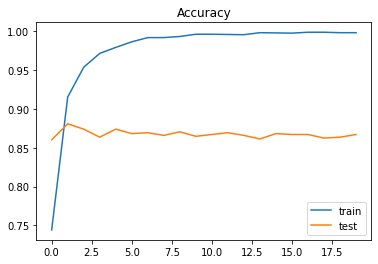

In [ ]:
# 시각화
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','test'], loc='best')
plt.show()

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import model_from_json


# 텍스트 준비하기 --- ( ※ 1)
text1 = """
대통령이 북한과 관련된 이야기로 한미 정상회담을 준비하고 있습니다.
"""
text2 = """
쏘카·롯데지주 \'미래 모빌리티 생태계 확장을 위한 업무협약\'[쏘카 제공. 재판매 및 DB 금지](서울=연합뉴스) 이영섭 기자 = 
승차 공유 플랫폼 쏘카는 롯데지주와 \'미래 모빌리티 생태계 확장을 위한 업무협약\'을 맺었다고 8일 밝혔다.    
양사는 쏘카의 모빌리티 플랫폼 운영 역량과 롯데그룹의 유통·호텔 오프라인 거점을 활용해 사업 협력을 추진할 방침이다.    
구체적으로 롯데의 백화점, 마트, 호텔 등을 모빌리티 서비스 이용자가 방문하기에 좋은 거점으로 바꾸고 이용자층을 늘리기 위한 마케팅에 협업한다.    
또 사물인터넷 클라우드에 기반한 쏘카의 차량 관제·관리 체계와 롯데의 유통 체계를 접목한 인공지능 기반 물류 사업을 공동으로 추진한다.    
박재욱 쏘카 대표는 "양사가 온·오프라인 역량을 결합해 폭넓은 시너지가 기대된다"고 말했다.
"""
text3 = """
예스24는 오는 5월1일까지 '세계 책의 날 기획전'을 열고 다양한 이벤트를 진행한다고 21일 밝혔다.
이번 기획전에서는 독자들이 서재에 있지만 아직 완독하지 못한 도서를 읽도록 돕는 '내 서재의 벽돌책을 공개합니다!' 이벤트가 진행된다. 구입 후 읽지 못한 '벽돌책'을 골라 댓글로 남기면 100명을 추첨해 포인트 1000원을 증정한다.
또한 기획전 대상 도서를 2만 원 이상 구매 시 '얼리리더 뱃지'와 '모나미 153 어린왕자 볼펜 세트'를 선물하며, 전국 7개 오프라인 매장에서는 23일 세계 책의 날 당일 구매 고객 모두에게 ‘모나미 153 어린왕자 볼펜’을 증정한다.
예스24 관계자는 "세계 책의 날을 기념해 일상 속에 잠시 잊고 지냈던 독서의 기쁨을 다시 상기시키는 이벤트를 준비했다"며 "이번 기획전이 책과 독서의 소중함을 재발견하고 함께 나누는 기회가 되길 바란다"고 전했다.
"""

text4 ="""
증권사들은 LG전자에 대해 일제히 ‘매수’ 의견을 내놨다. 대외적인 위험 요소가 여전히 남아있지만 기업 가치에 비해 여전히 주가가 
낮게 책정됐다는 게 공통적인 의견이다. 목표주가는 미래에셋증권(19만원), 삼성증권(18만원) 하이투자증권(18만5000원), 
이베스트투자증권(18만1000원), 대신증권(18만원) 등 18만∼19만원 선으로 유지했다.
"""

text5 = """
최종 후보에 올라 韓 작품으론 세 번째번역가 안톤 허도한국인 첫 쇼트리스트내달 26일 수상작 발표정보라 
작가의 단편 소설집 《저주토끼》(사진)가 영국 최고 권위 문학상인 부커상 인터내셔널 부문 최종 후보(쇼트리스트)에 올랐다. 
부커상은 노벨문학상, 프랑스 공쿠르상과 함께 세계 3대 문학상으로 꼽힌다.영국 부커재단은 7일 《저주토끼》를 비롯한 2022년 
부커상 인터내셔널 부문 최종 후보작 여섯 편을 발표했다. 《저주토끼》를 번역한 한국인 번역가 안톤 허(한국명 허정범·41)가 
최종 후보에 같이 이름을 올렸다. 롱리스트에 들었던 박상영 작가의 《대도시의 사랑법》은 최종 후보에 들지 못했다. 한국 작가 작품이 
이 부문 최종 후보에 오른 것은 2016년 수상한 한강 작가의 《채식주의자》, 2018년 한 작가의 다른 작품인 《흰》에 이어 세 번째다. 
한국 번역가가 쇼트리스트에 오른 것은 이번이 처음이다. 수상작은 다음달 26일 발표된다.정보라·안톤 허《저주토끼》는 판타지·호러 단편 10편을 담고 있다. 
저주와 복수, 유령 같은 소재로 현실 사회의 비이성을 드러내는 일종의 우화 소설이다. 부커재단은 이 작품에 대해 
환상적이고 초현실적인 요소를 활용해 현대의 가부장제와 자본주의의 참혹한 공포 및 잔혹함을 이야기한다”고 평했다.정 작가는 기자와의 통화에서 
“한국에서는 처음으로 장르문학으로 부커상 후보에 올라 기쁘다”며 “장르문학을 써온 작가로서 좀 더 자유롭게 쓰고 싶은 글을 
계속 써나갈 수 있겠다는 자신감을 얻게 됐다”고 말했다.이 작품은 안톤 허의 제안으로 영어판이 출간됐다. 그는 “유색인종 영어 번역가로서 
살아남기 위해 노력했던 날들을 인정받은 기분”이라며 “다양한 작품을 발굴하고 소개하려는 노력을 지속하겠다”고 말했다.
"""
# TF-IDF 사전 읽어 들이기 --- (*2)
tfidf.load_dic("genre-tfidf.dic")

# Keras 모델 정의하고 가중치 데이터 읽어 들이기 --- (*3)
nb_classes = 4
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])
model.load_weights('genre-model.hdf5')

# 텍스트 지정해서 판별하기 --- (*4)
def check_genre(text):
    # 레이블 정의하기
    LABELS = ["정치", "경제", "사회 ", "세계"]
    # TF-IDF 벡터로 변환하기 -- (*5)
    data = tfidf.calc_text(text)
    # MLP로 예측하기 --- (*6)
    pre = model.predict(np.array([data]))[0]
    n = pre.argmax()
    print(LABELS[n], "(", pre[n], ")")
    return LABELS[n], float(pre[n]), int(n) 

if __name__ == '__main__':
    check_genre(text1)
    check_genre(text2)
    check_genre(text3)
    check_genre(text4)
    check_genre(text5)


정치 ( 0.9999969 )
경제 ( 0.99873096 )
경제 ( 0.99999917 )
경제 ( 1.0 )
세계 ( 0.8239959 )


In [ ]:
# 14개 카테고리 (불용어처리 o)

In [ ]:
# 토큰화 사용자 함수 설정 (+ 토큰화된 단어들을 리스트 타입으로)
from konlpy.tag import Okt

okt = Okt()
def tokenize(text):
  result = []
  words = okt.morphs(text, norm=True, stem=True)
  return result.append(words)

In [ ]:
word_dic = {'_id': 0} # 단어 사전
dt_dic = {} # 문장 전체에서의 단어 출현 횟수
files = [] # 문서들을 저장할 리스트


# 단어별 id부여
def words_to_ids(words, auto_add = True):
    result = []
    for w in words:
        if w in word_dic:
            result.append(word_dic[w])
            continue
        elif auto_add:
            id = word_dic[w] = word_dic['_id']
            word_dic['_id'] += 1
            result.append(id)
    return result


def add_text(text):
    ids = words_to_ids(tokenize(text))
    files.append(ids)

def calc_files():
    global dt_dic
    result = []
    doc_count = len(files)
    dt_dic = {}
    for words in files:
        used_word = {}
        data = np.zeros(word_dic['_id'])
        for id in words:
            data[id] += 1
            used_word[id] = 1
        for id in used_word:
            if not(id in dt_dic): dt_dic[id] = 0
            dt_dic[id] += 1
        data = data / len(words) 
        result.append(data)
    for i, doc in enumerate(result):
        for id, v in enumerate(doc):
            idf = np.log(doc_count / dt_dic[id]) + 1
            doc[id] = min([doc[id] * idf, 1.0])
        result[i] = doc
    return result

In [ ]:
from konlpy.tag import Okt
import pickle
import numpy as np
import tfidf2

# 변수 초기화
y = [] # label 값
x = [] # tfidf 계산 값

for t in range(texts.shape[0]):
  tfidf2.add_text(texts.article[t])
  y.append(texts.target[t])

x = tfidf2.calc_files()
with open('genre2.pickle','wb') as f:
  pickle.dump([y,x], f)
tfidf2.save_dic('genre-tfidf2.dic')
print('ok')

ok


In [ ]:
data = pickle.load(open('genre2.pickle', 'rb'))
print(len(data[0]))
print(len(data))
print(data[0])
# print(data[1])

4359
2
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# 딥러닝으로 정답률 개선하기
# 레이블 데이터를 one-hot 형식으로 변환
# 입력과 출력
import pickle
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import h5py
# import warnings
# warnings.filterwarnings('ignore')

nb_classes = 14

data = pickle.load(open('genre2.pickle', 'rb'))
y = data[0]
x = data[1]
print(len(x))
print(len(y))

# 레이블 one-hot 형식 변환

y = to_categorical(y,nb_classes)
in_size = x[0].shape[0]
print(in_size)

4359
4359
26167


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x),np.array(y), test_size=0.2)

In [ ]:
print(x_train.shape)
x_train[0]

(3487, 26167)


array([0.        , 0.        , 0.00964317, ..., 0.        , 0.        ,
       0.        ])

In [ ]:
y_train.shape
y_train[1]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:


# 모델 정의
# 렐루 활성화 함수를 사용한 완전 연결 층을 추가합니다.
# 활성화 함수 ReLU : f(z) = max(0,z) z은 가중치가 적용된 입력과 절편의 합
# z이 0보다 크면 z을 반환하고 그렇지 않으면 0을 반환
# 다중 분류 : 소프트맥스 활성화 함수와 k개의 유닛
# 손실 함수를 정의 : 이진 크로스 엔트로피(이진 분류), 범주형 크로스 엔트로피(다중 분류), 평균 제곱 오차(회귀)
# 옵티마이저(가장 작은 손실 함수 오차를 만드는 모델 파라미터 값을 찾는 전략)
# 드롭아웃 과대적합 줄이기
model = Sequential()  # 순차적 신경망 추가

model.add(Dense(512, activation='relu', input_shape=(in_size,)))  # 입력 데이터 차원수, 유닛수 512
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes,activation='softmax'))  # 출력 유닛수 14

# 모델 컴파일
model.compile(loss='categorical_crossentropy',  # 손실 함수
             optimizer=RMSprop(),  # 파라미터 옵티마이저(RMSprop:학습률을 가중치에 맞춰 제어하는 기법)
             metrics=['accuracy'])

# 학습 실행
hist = model.fit(x_train, y_train,
                batch_size=128,  # 1회 계산시 사용할 데이터 수
                epochs=20,  # 반복 횟수
                verbose=1,
                validation_data=(x_test,y_test))
score = model.evaluate(x_test,y_test,verbose=1)
print('정확도:', score[1], 'loss=', score[0])

model.save_weights('genre-model2.hdf5')

Epoch 1/20
28/28 [==============================] - 8s 237ms/step - loss: 1.9173 - accuracy: 0.4328 - val_loss: 1.3935 - val_accuracy: 0.6158
Epoch 2/20
28/28 [==============================] - 6s 216ms/step - loss: 1.0115 - accuracy: 0.6888 - val_loss: 1.0952 - val_accuracy: 0.6697
Epoch 3/20
28/28 [==============================] - 6s 215ms/step - loss: 0.6455 - accuracy: 0.7961 - val_loss: 1.0197 - val_accuracy: 0.6904
Epoch 4/20
28/28 [==============================] - 6s 213ms/step - loss: 0.4280 - accuracy: 0.8712 - val_loss: 1.0548 - val_accuracy: 0.6972
Epoch 5/20
28/28 [==============================] - 6s 214ms/step - loss: 0.2822 - accuracy: 0.9143 - val_loss: 1.0737 - val_accuracy: 0.7064
Epoch 6/20
28/28 [==============================] - 6s 215ms/step - loss: 0.1950 - accuracy: 0.9378 - val_loss: 1.1754 - val_accuracy: 0.6938
Epoch 7/20
28/28 [==============================] - 6s 214ms/step - loss: 0.1321 - accuracy: 0.9599 - val_loss: 1.2185 - val_accuracy: 0.7076
Epoch 

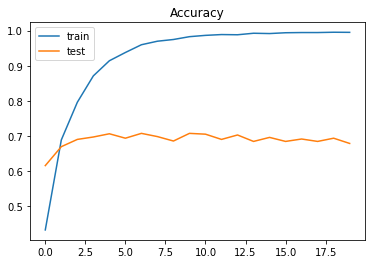

In [ ]:
# 시각화
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','test'], loc='best')
plt.show()

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import model_from_json


# 텍스트 준비하기 --- ( ※ 1)
text1 = """
대통령이 북한과 관련된 이야기로 한미 정상회담을 준비하고 있습니다.
"""
text2 = """
쏘카·롯데지주 \'미래 모빌리티 생태계 확장을 위한 업무협약\'[쏘카 제공. 재판매 및 DB 금지](서울=연합뉴스) 이영섭 기자 = 
승차 공유 플랫폼 쏘카는 롯데지주와 \'미래 모빌리티 생태계 확장을 위한 업무협약\'을 맺었다고 8일 밝혔다.    
양사는 쏘카의 모빌리티 플랫폼 운영 역량과 롯데그룹의 유통·호텔 오프라인 거점을 활용해 사업 협력을 추진할 방침이다.    
구체적으로 롯데의 백화점, 마트, 호텔 등을 모빌리티 서비스 이용자가 방문하기에 좋은 거점으로 바꾸고 이용자층을 늘리기 위한 마케팅에 협업한다.    
또 사물인터넷 클라우드에 기반한 쏘카의 차량 관제·관리 체계와 롯데의 유통 체계를 접목한 인공지능 기반 물류 사업을 공동으로 추진한다.    
박재욱 쏘카 대표는 "양사가 온·오프라인 역량을 결합해 폭넓은 시너지가 기대된다"고 말했다.
"""
text3 = """
예스24는 오는 5월1일까지 '세계 책의 날 기획전'을 열고 다양한 이벤트를 진행한다고 21일 밝혔다.
이번 기획전에서는 독자들이 서재에 있지만 아직 완독하지 못한 도서를 읽도록 돕는 '내 서재의 벽돌책을 공개합니다!' 이벤트가 진행된다. 구입 후 읽지 못한 '벽돌책'을 골라 댓글로 남기면 100명을 추첨해 포인트 1000원을 증정한다.
또한 기획전 대상 도서를 2만 원 이상 구매 시 '얼리리더 뱃지'와 '모나미 153 어린왕자 볼펜 세트'를 선물하며, 전국 7개 오프라인 매장에서는 23일 세계 책의 날 당일 구매 고객 모두에게 ‘모나미 153 어린왕자 볼펜’을 증정한다.
예스24 관계자는 "세계 책의 날을 기념해 일상 속에 잠시 잊고 지냈던 독서의 기쁨을 다시 상기시키는 이벤트를 준비했다"며 "이번 기획전이 책과 독서의 소중함을 재발견하고 함께 나누는 기회가 되길 바란다"고 전했다.
"""

text4 ="""
증권사들은 LG전자에 대해 일제히 ‘매수’ 의견을 내놨다. 대외적인 위험 요소가 여전히 남아있지만 기업 가치에 비해 여전히 주가가 
낮게 책정됐다는 게 공통적인 의견이다. 목표주가는 미래에셋증권(19만원), 삼성증권(18만원) 하이투자증권(18만5000원), 
이베스트투자증권(18만1000원), 대신증권(18만원) 등 18만∼19만원 선으로 유지했다.
"""

text5 = """
최종 후보에 올라 韓 작품으론 세 번째번역가 안톤 허도한국인 첫 쇼트리스트내달 26일 수상작 발표정보라 
작가의 단편 소설집 《저주토끼》(사진)가 영국 최고 권위 문학상인 부커상 인터내셔널 부문 최종 후보(쇼트리스트)에 올랐다. 
부커상은 노벨문학상, 프랑스 공쿠르상과 함께 세계 3대 문학상으로 꼽힌다.영국 부커재단은 7일 《저주토끼》를 비롯한 2022년 
부커상 인터내셔널 부문 최종 후보작 여섯 편을 발표했다. 《저주토끼》를 번역한 한국인 번역가 안톤 허(한국명 허정범·41)가 
최종 후보에 같이 이름을 올렸다. 롱리스트에 들었던 박상영 작가의 《대도시의 사랑법》은 최종 후보에 들지 못했다. 한국 작가 작품이 
이 부문 최종 후보에 오른 것은 2016년 수상한 한강 작가의 《채식주의자》, 2018년 한 작가의 다른 작품인 《흰》에 이어 세 번째다. 
한국 번역가가 쇼트리스트에 오른 것은 이번이 처음이다. 수상작은 다음달 26일 발표된다.정보라·안톤 허《저주토끼》는 판타지·호러 단편 10편을 담고 있다. 
저주와 복수, 유령 같은 소재로 현실 사회의 비이성을 드러내는 일종의 우화 소설이다. 부커재단은 이 작품에 대해 
환상적이고 초현실적인 요소를 활용해 현대의 가부장제와 자본주의의 참혹한 공포 및 잔혹함을 이야기한다”고 평했다.정 작가는 기자와의 통화에서 
“한국에서는 처음으로 장르문학으로 부커상 후보에 올라 기쁘다”며 “장르문학을 써온 작가로서 좀 더 자유롭게 쓰고 싶은 글을 
계속 써나갈 수 있겠다는 자신감을 얻게 됐다”고 말했다.이 작품은 안톤 허의 제안으로 영어판이 출간됐다. 그는 “유색인종 영어 번역가로서 
살아남기 위해 노력했던 날들을 인정받은 기분”이라며 “다양한 작품을 발굴하고 소개하려는 노력을 지속하겠다”고 말했다.
"""
# TF-IDF 사전 읽어 들이기 --- (*2)
tfidf2.load_dic("genre-tfidf2.dic")

# Keras 모델 정의하고 가중치 데이터 읽어 들이기 --- (*3)
nb_classes = 14
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])
model.load_weights('genre-model2.hdf5')

# 텍스트 지정해서 판별하기 --- (*4)
def check_genre(text):
    # 레이블 정의하기
    LABELS = ["정치","외교","행정","투자","경제","생활 ","사건","복지","보건","사회","아시아","미국","유럽","세계"]
    # TF-IDF 벡터로 변환하기 -- (*5)
    data = tfidf2.calc_text(text)
    # MLP로 예측하기 --- (*6)
    pre = model.predict(np.array([data]))[0]
    n = pre.argmax()
    print(LABELS[n], "(", pre[n], ")")
    return LABELS[n], float(pre[n]), int(n) 

if __name__ == '__main__':
    check_genre(text1)
    check_genre(text2)
    check_genre(text3)
    check_genre(text4)
    check_genre(text5)


외교 ( 0.86390346 )
경제 ( 0.9975006 )
경제 ( 0.9771314 )
투자 ( 1.0 )
정치 ( 0.61529976 )


In [ ]:
# 14개 카테고리 (불용어처리 x)

In [ ]:
from konlpy.tag import Okt
import pickle
import numpy as np
import tfidf

# 변수 초기화
y = [] # label 값
x = [] # tfidf 계산 값

for t in range(texts.shape[0]):
  tfidf.add_text(texts.article[t])
  y.append(texts.target[t])

x = tfidf.calc_files()
with open('genre14.pickle','wb') as f:
  pickle.dump([y,x], f)
tfidf.save_dic('genre-tfidf14.dic')
print('ok')

ok


In [ ]:
import pickle
data = pickle.load(open('genre14.pickle', 'rb'))
print(len(data[0]))
print(len(data))
print(data[0])
# print(data[1])

In [ ]:
# 딥러닝으로 정답률 개선하기
# 레이블 데이터를 one-hot 형식으로 변환
# 입력과 출력
import pickle
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import h5py
# import warnings
# warnings.filterwarnings('ignore')

nb_classes = 14

data = pickle.load(open('genre14.pickle', 'rb'))
y = data[0]
x = data[1]

# 레이블 one-hot 형식 변환
nb_classes = 14
y = to_categorical(y,nb_classes)
in_size = x[0].shape[0] # 입력데이터 차원수 변환
print(in_size)

4359
4359
26167


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(np.array(x),np.array(y), test_size=0.2)

In [ ]:
print(x_train.shape)
x_train[0]

(3487, 26167)


array([0.       , 0.       , 0.0193736, ..., 0.       , 0.       ,
       0.       ])

In [ ]:
y_train.shape
y_train[1]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [ ]:


# 모델 정의
# 렐루 활성화 함수를 사용한 완전 연결 층을 추가합니다.
# 활성화 함수 ReLU : f(z) = max(0,z) z은 가중치가 적용된 입력과 절편의 합
# z이 0보다 크면 z을 반환하고 그렇지 않으면 0을 반환
# 다중 분류 : 소프트맥스 활성화 함수와 k개의 유닛
# 손실 함수를 정의 : 이진 크로스 엔트로피(이진 분류), 범주형 크로스 엔트로피(다중 분류), 평균 제곱 오차(회귀)
# 옵티마이저(가장 작은 손실 함수 오차를 만드는 모델 파라미터 값을 찾는 전략)
# 드롭아웃 과대적합 줄이기

model = Sequential()  # 순차적 신경망 구축

model.add(Dense(512, activation='relu', input_shape=(in_size,)))  # 입력 데이터 차원수, 유닛수 512
model.add(Dropout(0.2)) # 과대적합을 줄이기 위해 드롭아웃
model.add(Dense(512, activation='relu')) # 활성화함수
model.add(Dropout(0.2))
model.add(Dense(nb_classes,activation='softmax'))  # 출력 유닛수 14

# 모델 컴파일
model.compile(loss='categorical_crossentropy',  # 손실 함수 다중분류 
             optimizer=RMSprop(),  # 파라미터 옵티마이저
             metrics=['accuracy'])

# 학습 실행
hist = model.fit(x_train, y_train,
                batch_size=128,  # 1회 계산시 사용할 데이터 수
                epochs=20,  # 반복 횟수
                verbose=1,
                validation_data=(x_test,y_test))
score = model.evaluate(x_test,y_test,verbose=1)
print('정확도:', score[1], 'loss=', score[0])

model.save_weights('genre-model14.hdf5') # 가중치만 저장

Epoch 1/20
28/28 [==============================] - 9s 302ms/step - loss: 1.8977 - accuracy: 0.4566 - val_loss: 1.3233 - val_accuracy: 0.5791
Epoch 2/20
28/28 [==============================] - 6s 216ms/step - loss: 0.9969 - accuracy: 0.6880 - val_loss: 1.0288 - val_accuracy: 0.6892
Epoch 3/20
28/28 [==============================] - 6s 218ms/step - loss: 0.6458 - accuracy: 0.7981 - val_loss: 0.9633 - val_accuracy: 0.6697
Epoch 4/20
28/28 [==============================] - 6s 217ms/step - loss: 0.4268 - accuracy: 0.8718 - val_loss: 0.9938 - val_accuracy: 0.6617
Epoch 5/20
28/28 [==============================] - 6s 217ms/step - loss: 0.2899 - accuracy: 0.9134 - val_loss: 1.0778 - val_accuracy: 0.6755
Epoch 6/20
28/28 [==============================] - 6s 217ms/step - loss: 0.1984 - accuracy: 0.9412 - val_loss: 1.0505 - val_accuracy: 0.6846
Epoch 7/20
28/28 [==============================] - 6s 219ms/step - loss: 0.1378 - accuracy: 0.9553 - val_loss: 1.0720 - val_accuracy: 0.7099
Epoch 

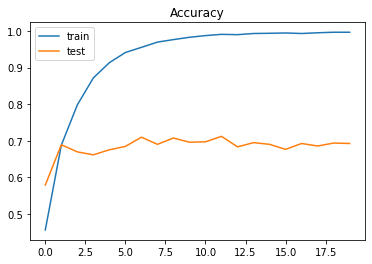

In [ ]:
# 시각화
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train','test'], loc='best')
plt.show()

In [ ]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import model_from_json


# 텍스트 준비하기 --- ( ※ 1)
text1 = """
대통령이 북한과 관련된 이야기로 한미 정상회담을 준비하고 있습니다.
"""
text2 = """
쏘카·롯데지주 \'미래 모빌리티 생태계 확장을 위한 업무협약\'[쏘카 제공. 재판매 및 DB 금지](서울=연합뉴스) 이영섭 기자 = 
승차 공유 플랫폼 쏘카는 롯데지주와 \'미래 모빌리티 생태계 확장을 위한 업무협약\'을 맺었다고 8일 밝혔다.    
양사는 쏘카의 모빌리티 플랫폼 운영 역량과 롯데그룹의 유통·호텔 오프라인 거점을 활용해 사업 협력을 추진할 방침이다.    
구체적으로 롯데의 백화점, 마트, 호텔 등을 모빌리티 서비스 이용자가 방문하기에 좋은 거점으로 바꾸고 이용자층을 늘리기 위한 마케팅에 협업한다.    
또 사물인터넷 클라우드에 기반한 쏘카의 차량 관제·관리 체계와 롯데의 유통 체계를 접목한 인공지능 기반 물류 사업을 공동으로 추진한다.    
박재욱 쏘카 대표는 "양사가 온·오프라인 역량을 결합해 폭넓은 시너지가 기대된다"고 말했다.
"""
text3 = """
예스24는 오는 5월1일까지 '세계 책의 날 기획전'을 열고 다양한 이벤트를 진행한다고 21일 밝혔다.
이번 기획전에서는 독자들이 서재에 있지만 아직 완독하지 못한 도서를 읽도록 돕는 '내 서재의 벽돌책을 공개합니다!' 이벤트가 진행된다. 구입 후 읽지 못한 '벽돌책'을 골라 댓글로 남기면 100명을 추첨해 포인트 1000원을 증정한다.
또한 기획전 대상 도서를 2만 원 이상 구매 시 '얼리리더 뱃지'와 '모나미 153 어린왕자 볼펜 세트'를 선물하며, 전국 7개 오프라인 매장에서는 23일 세계 책의 날 당일 구매 고객 모두에게 ‘모나미 153 어린왕자 볼펜’을 증정한다.
예스24 관계자는 "세계 책의 날을 기념해 일상 속에 잠시 잊고 지냈던 독서의 기쁨을 다시 상기시키는 이벤트를 준비했다"며 "이번 기획전이 책과 독서의 소중함을 재발견하고 함께 나누는 기회가 되길 바란다"고 전했다.
"""

text4 ="""
증권사들은 LG전자에 대해 일제히 ‘매수’ 의견을 내놨다. 대외적인 위험 요소가 여전히 남아있지만 기업 가치에 비해 여전히 주가가 
낮게 책정됐다는 게 공통적인 의견이다. 목표주가는 미래에셋증권(19만원), 삼성증권(18만원) 하이투자증권(18만5000원), 
이베스트투자증권(18만1000원), 대신증권(18만원) 등 18만∼19만원 선으로 유지했다.
"""

text5 = """
최종 후보에 올라 韓 작품으론 세 번째번역가 안톤 허도한국인 첫 쇼트리스트내달 26일 수상작 발표정보라 
작가의 단편 소설집 《저주토끼》(사진)가 영국 최고 권위 문학상인 부커상 인터내셔널 부문 최종 후보(쇼트리스트)에 올랐다. 
부커상은 노벨문학상, 프랑스 공쿠르상과 함께 세계 3대 문학상으로 꼽힌다.영국 부커재단은 7일 《저주토끼》를 비롯한 2022년 
부커상 인터내셔널 부문 최종 후보작 여섯 편을 발표했다. 《저주토끼》를 번역한 한국인 번역가 안톤 허(한국명 허정범·41)가 
최종 후보에 같이 이름을 올렸다. 롱리스트에 들었던 박상영 작가의 《대도시의 사랑법》은 최종 후보에 들지 못했다. 한국 작가 작품이 
이 부문 최종 후보에 오른 것은 2016년 수상한 한강 작가의 《채식주의자》, 2018년 한 작가의 다른 작품인 《흰》에 이어 세 번째다. 
한국 번역가가 쇼트리스트에 오른 것은 이번이 처음이다. 수상작은 다음달 26일 발표된다.정보라·안톤 허《저주토끼》는 판타지·호러 단편 10편을 담고 있다. 
저주와 복수, 유령 같은 소재로 현실 사회의 비이성을 드러내는 일종의 우화 소설이다. 부커재단은 이 작품에 대해 
환상적이고 초현실적인 요소를 활용해 현대의 가부장제와 자본주의의 참혹한 공포 및 잔혹함을 이야기한다”고 평했다.정 작가는 기자와의 통화에서 
“한국에서는 처음으로 장르문학으로 부커상 후보에 올라 기쁘다”며 “장르문학을 써온 작가로서 좀 더 자유롭게 쓰고 싶은 글을 
계속 써나갈 수 있겠다는 자신감을 얻게 됐다”고 말했다.이 작품은 안톤 허의 제안으로 영어판이 출간됐다. 그는 “유색인종 영어 번역가로서 
살아남기 위해 노력했던 날들을 인정받은 기분”이라며 “다양한 작품을 발굴하고 소개하려는 노력을 지속하겠다”고 말했다.
"""
# TF-IDF 사전 읽어 들이기 --- (*2)
tfidf.load_dic("genre-tfidf14.dic")

# Keras 모델 정의하고 가중치 데이터 읽어 들이기 --- (*3)
nb_classes = 14
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(in_size,)))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(nb_classes, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer=RMSprop(),
    metrics=['accuracy'])
model.load_weights('genre-model14.hdf5') # 딥러닝 모델에 가중치만 적용

# 텍스트 지정해서 판별하기 --- (*4)
def check_genre(text):
    # 레이블 정의하기
    LABELS = ["정치","외교","행정","투자","경제","생활 ","사건","복지","보건","사회","아시아","미국","유럽","세계"]
    # TF-IDF 벡터로 변환하기 -- (*5)
    data = tfidf.calc_text(text)
    # MLP로 예측하기 --- (*6)
    pre = model.predict(np.array([data]))[0] # 확률값
    n = pre.argmax() # 가장 큰수의 인덱스 반환
    print(LABELS[n], "(", pre[n], ")")
    return LABELS[n], float(pre[n]), int(n) 

if __name__ == '__main__':
    check_genre(text1)
    check_genre(text2)
    check_genre(text3)
    check_genre(text4)
    check_genre(text5)


외교 ( 0.49143675 )
생활  ( 0.51601136 )
경제 ( 0.9986431 )
투자 ( 0.9999999 )
세계 ( 0.75266904 )
